# TP2 - CV avec Keras

In [2]:
! pip uninstall torchvision -y

In [3]:
! pip install keras
! pip install tensorflow
! pip install tensorflow-datasets
! pip install tensorflow[and-cuda]
! pip install numpy==1.26.4

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


# Partie 1 - Manipulations de base avec Keras pour la classification d'image

## Test de Keras avec quelques images de référence

In [15]:
import keras
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
import numpy as np

model = VGG16(weights='imagenet', include_top=True)

for animal in ["elephant", "fish", "lion"]:
    img_path = f'image/{animal}.jpg'
    img = keras.utils.load_img(img_path, target_size=(224, 224))
    x = keras.utils.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    features = model.predict(x)

    predictedClasses = decode_predictions(features, top=5)[0]

    for predictedClass, desc, prob in predictedClasses:
        print(desc, prob)

2025-01-08 05:03:01.602938: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.


KeyboardInterrupt: 

## Définition et application d'un domaine d'adaptation: finetuning sur les chats et chiens

In [16]:
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input, decode_predictions
from keras import layers

import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import keras
import os

In [17]:
imageSize = 224
batchSize = 64

# load dataset
dataset_name = "cats_vs_dogs"
(ds_train, ds_test), ds_info = tfds.load(
    dataset_name, split=["train[:75%]", "train[75%:]"], with_info=True, as_supervised=True
)
NUM_CLASSES = ds_info.features["label"].num_classes

In [18]:
# resize the datasets to the desired size
size = (imageSize, imageSize)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))

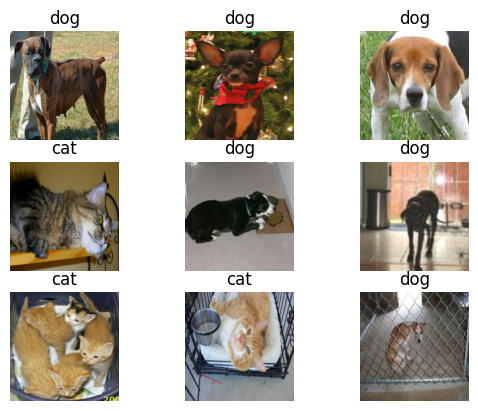

In [19]:
# visualize the first 9 images of the training dataset
def format_label(label):
    string_label = label_info.int2str(label)
    return string_label

label_info = ds_info.features["label"]
for i, (image, label) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title("{}".format(format_label(label)))
    plt.axis("off")

2025-01-08 05:03:17.127862: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


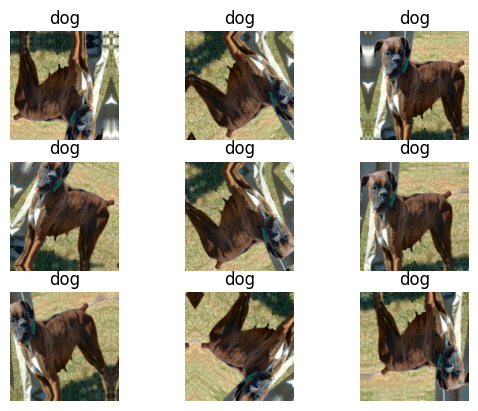

In [20]:
# data augmentation by randomly rotating, translating, flippign and changing the contrast of the images
img_augmentation_layers = [
    layers.RandomRotation(factor=0.15),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.1),
]

def img_augmentation(images):
    for layer in img_augmentation_layers:
        images = layer(images)
    return images

for image, label in ds_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(np.expand_dims(image.numpy(), axis=0))
        aug_img = np.array(aug_img)
        plt.imshow(aug_img[0].astype("uint8"))
        plt.title("{}".format(format_label(label)))
        plt.axis("off")



In [21]:
def input_preprocess_train(image, label):
    image = img_augmentation(image)
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


def input_preprocess_test(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

ds_train = ds_train.map(input_preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.batch(batch_size=batchSize, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(input_preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(batch_size=batchSize, drop_remainder=True)

In [25]:
def buildModel(nbClasses):
    inputs = layers.Input(shape=(imageSize, imageSize, 3))

    model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=inputs)
    model.trainable = False

    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(nbClasses, activation="softmax", name="pred")(x)
    
    model = keras.Model(inputs, outputs, name="MobileNetV2")
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(
        optimizer=optimizer, loss="binary_crossentropy", metrics=[keras.metrics.BinaryAccuracy()]
    )
    
    return model

def make_checkpoint(checkpointPath):
    checkpoint_dir = os.path.dirname(checkpointPath)

    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpointPath,
                                                    save_weights_only=True,
                                                    verbose=1)
    
    return cp_callback

In [23]:
def plot_hist(hist):
    # accuracy
    plt.plot(hist.history['binary_accuracy'])
    plt.plot(hist.history['val_binary_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # loss
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

/tmp/ipykernel_33385/3077203420.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=inputs)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20


2025-01-08 05:04:32.728611: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4944', 4 bytes spill stores, 4 bytes spill loads



272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - binary_accuracy: 0.6284 - loss: 0.7125
Epoch 1: saving model to MobileNet_firstStep_custom.weights.h5
272/272 ━━━━━━━━━━━━━━━━━━━━ 50s 144ms/step - binary_accuracy: 0.6285 - loss: 0.7123 - val_binary_accuracy: 0.6712 - val_loss: 0.6073
Epoch 2/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - binary_accuracy: 0.6883 - loss: 0.6152
Epoch 2: saving model to MobileNet_firstStep_custom.weights.h5
272/272 ━━━━━━━━━━━━━━━━━━━━ 31s 112ms/step - binary_accuracy: 0.6883 - loss: 0.6151 - val_binary_accuracy: 0.6766 - val_loss: 0.6040
Epoch 3/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - binary_accuracy: 0.7005 - loss: 0.5930
Epoch 3: saving model to MobileNet_firstStep_custom.weights.h5
272/272 ━━━━━━━━━━━━━━━━━━━━ 30s 111ms/step - binary_accuracy: 0.7005 - loss: 0.5930 - val_binary_accuracy: 0.6901 - val_loss: 0.5863
Epoch 4/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - binary_accuracy: 0.6968 - loss: 0.5883
Epoch 4: saving model to MobileNet_first

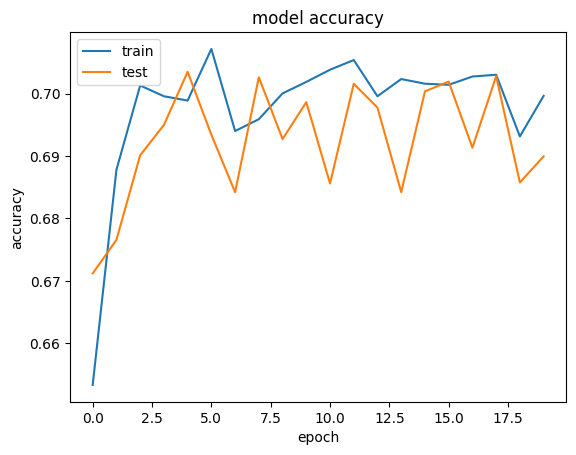

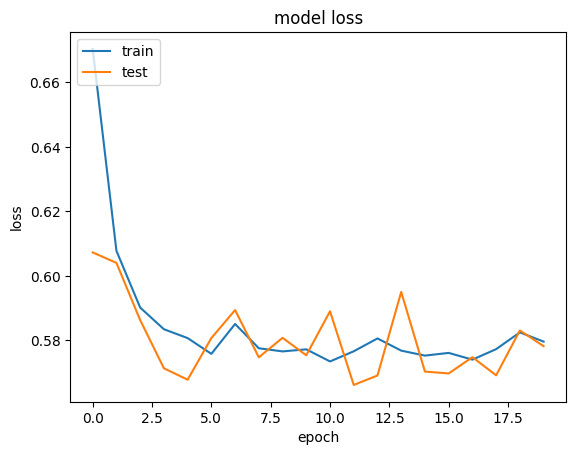

90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - binary_accuracy: 0.6831 - loss: 0.5831
Restored model, accuracy: 68.99%


In [26]:
# train the first layer 
model = buildModel(nbClasses=NUM_CLASSES)
checkpoint_path = "MobileNet_firstStep_custom.weights.h5"
checkpoint = make_checkpoint(checkpoint_path)


epochs = 20
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, callbacks=[checkpoint])

plot_hist(hist)

model.load_weights(checkpoint_path)
loss, acc = model.evaluate(ds_test)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))


Epoch 1/5


2025-01-08 05:15:25.364691: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109632 bytes after encountering the first element of size 67109632 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - binary_accuracy: 0.6923 - loss: 0.5875
Epoch 1: saving model to MobileNet_secondStep_custom.weights.h5
272/272 ━━━━━━━━━━━━━━━━━━━━ 39s 117ms/step - binary_accuracy: 0.6923 - loss: 0.5874 - val_binary_accuracy: 0.6585 - val_loss: 0.6674
Epoch 2/5
  2/272 ━━━━━━━━━━━━━━━━━━━━ 24s 90ms/step - binary_accuracy: 0.7070 - loss: 0.6106 

2025-01-08 05:16:01.504555: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109376 bytes after encountering the first element of size 67109376 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - binary_accuracy: 0.7156 - loss: 0.5538
Epoch 2: saving model to MobileNet_secondStep_custom.weights.h5
272/272 ━━━━━━━━━━━━━━━━━━━━ 32s 116ms/step - binary_accuracy: 0.7156 - loss: 0.5538 - val_binary_accuracy: 0.5939 - val_loss: 0.8298
Epoch 3/5
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - binary_accuracy: 0.7318 - loss: 0.5388
Epoch 3: saving model to MobileNet_secondStep_custom.weights.h5
272/272 ━━━━━━━━━━━━━━━━━━━━ 35s 123ms/step - binary_accuracy: 0.7318 - loss: 0.5387 - val_binary_accuracy: 0.4939 - val_loss: 2.3502
Epoch 4/5
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - binary_accuracy: 0.7423 - loss: 0.5257
Epoch 4: saving model to MobileNet_secondStep_custom.weights.h5
272/272 ━━━━━━━━━━━━━━━━━━━━ 31s 110ms/step - binary_accuracy: 0.7423 - loss: 0.5257 - val_binary_accuracy: 0.7113 - val_loss: 0.5737
Epoch 5/5
  2/272 ━━━━━━━━━━━━━━━━━━━━ 25s 95ms/step - binary_accuracy: 0.7344 - loss: 0.5567

2025-01-08 05:17:39.267058: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109376 bytes after encountering the first element of size 67109376 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - binary_accuracy: 0.7464 - loss: 0.5188
Epoch 5: saving model to MobileNet_secondStep_custom.weights.h5
272/272 ━━━━━━━━━━━━━━━━━━━━ 32s 116ms/step - binary_accuracy: 0.7465 - loss: 0.5188 - val_binary_accuracy: 0.7453 - val_loss: 0.5232


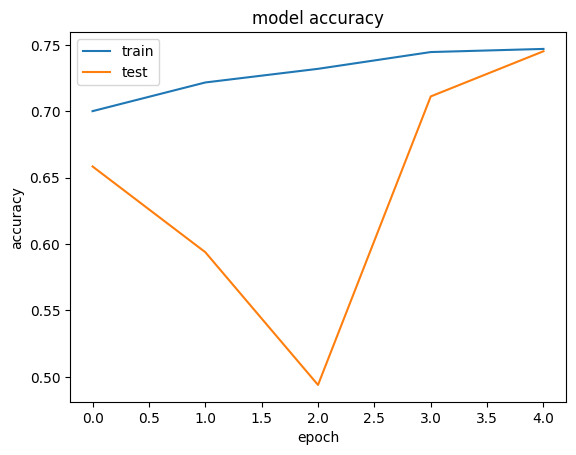

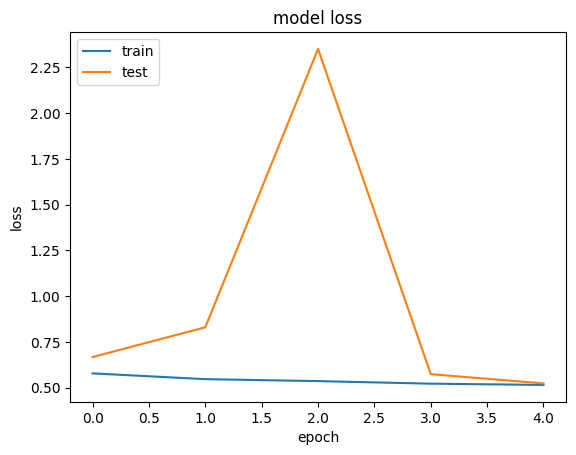

90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - binary_accuracy: 0.7402 - loss: 0.5292
Restored model, accuracy: 74.53%


In [27]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(
        optimizer=optimizer, loss="binary_crossentropy", metrics=[keras.metrics.BinaryAccuracy()]
    )

unfreeze_model(model)

checkpoint_path = "MobileNet_secondStep_custom.weights.h5"
checkpoint = make_checkpoint(checkpoint_path)


epochs = 5
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, callbacks=[checkpoint])

plot_hist(hist)

model.load_weights(checkpoint_path)
loss, acc = model.evaluate(ds_test)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

In [ ]:
# Test the final model on one final picture

img_path = "image/luna.jpg"
img = keras.utils.load_img(img_path, target_size=size)
x = keras.utils.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

features = model.predict(x)
# predictedClasses = decode_predictions(features, top=2)[0]
# for predictedClass, desc, prob in predictedClasses:
#     print(desc, prob)

Si j'en crois les labels de mes données de finetuning, (0 = chien, 1 = chat), mon modèle fine-tuné ne marche pas très bien...